# PARTE 1
## Exploración de datos

In [19]:
%pip install scikit-learn
# necesario porque de otra forma no me deja usar sklearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.model_selection import train_test_split
import re
from urllib.parse import urlparse, parse_qs
import math
import seaborn as sns
import os

In [21]:
df = pd.read_csv('dataset_pishing.csv')
df

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate


In [22]:
df.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [23]:
print(df['status'].value_counts())
print(df['status'].value_counts(normalize=True))

status
legitimate    5715
phishing      5715
Name: count, dtype: int64
status
legitimate    0.5
phishing      0.5
Name: proportion, dtype: float64


## Derivación de características
### Atributos del URL a agregar

**Generales**
- length_url - Longitud total de la URL
- num_dots_url - Cantidad de puntos "." en la URL
- num_hyph_url - Cantidad de guiones "-" en la URL
- num_slash_url - Cantidad de barras "/" en la URL
- num_special_chars_url - Total de caracteres especiales (@, ?, =, &, !, %, $, #, +, *, ~)

**Específicas del dominio**
- length_dom - Longitud del dominio
- num_dots_dom - Cantidad de puntos en el dominio (subdominios)
- dom_in_ip - Si el dominio está en formato IP (binaria)
- num_tld_url - Longitud del TLD (top level domain)

**Específicas del pathname**
- length_path - Longitud del path/pathname
- num_hyph_path - Cantidad de guiones en el path

**De parámetros**
- num_param - Número de parámetros (después de "?")
- length_param - Longitud total de los parámetros

**Características de Entropía**
- shannon_entropy - Entropía de Shannon de la URL
- relative_entropy - Entropía relativa (KL divergence)

## Preprocesamiento

In [24]:
SPECIAL_CHARS = "@?=&!%$#+*~"
def safe_urlparse(u):
    if pd.isna(u):
        return urlparse("")
    u = str(u).strip()
    if not u.startswith(("http://", "https://")):
        u = "http://" + u
    return urlparse(u)


def count_char(s, char):
    if s is None:
        return 0
    return str(s).count(char)


def count_special_chars(s):
    if s is None:
        return 0
    s = str(s)
    return sum(1 for c in s if c in SPECIAL_CHARS)


def is_ip_domain(domain):
    if domain is None:
        return 0
    domain = str(domain)

    # IPv4 simple
    pattern = r"^\d{1,3}(\.\d{1,3}){3}$"
    if re.match(pattern, domain):
        # validación básica 0-255
        parts = domain.split(".")
        for p in parts:
            if int(p) < 0 or int(p) > 255:
                return 0
        return 1
    return 0


def get_tld_length(domain):
    """
    Devuelve longitud del TLD.
    Ej: google.com -> com (3)
        something.co.uk -> uk (2)  (ojo: no detecta TLD compuesto)
    """
    if not domain:
        return 0
    parts = domain.split(".")
    if len(parts) < 2:
        return 0
    return len(parts[-1])

In [25]:
def shannon_entropy(s):
    # Entropía de Shannon: -sum(p_i log2 p_i)
    if s is None:
        return 0.0
    s = str(s)
    if len(s) == 0:
        return 0.0

    freq = {}
    for c in s:
        freq[c] = freq.get(c, 0) + 1

    ent = 0.0
    for count in freq.values():
        p = count / len(s)
        ent -= p * math.log2(p)

    return ent


def relative_entropy_kl(s):
    # Entropía relativa aproximada (KL divergence) contra una distribución uniforme.
    # - Se usa alfabeto basado en caracteres presentes en el string.
    # - KL(P || U) = sum(p_i log2(p_i / u_i))
    # donde U es uniforme (1/k).

    # Nota: esta implementación es una aproximación común para tareas académicas.
    if s is None:
        return 0.0
    s = str(s)
    if len(s) == 0:
        return 0.0

    freq = {}
    for c in s:
        freq[c] = freq.get(c, 0) + 1

    k = len(freq)  # tamaño del alfabeto observado
    if k == 0:
        return 0.0

    u = 1.0 / k

    kl = 0.0
    for count in freq.values():
        p = count / len(s)
        kl += p * math.log2(p / u)

    return kl


In [26]:
def extract_features(url):
    parsed = safe_urlparse(url)

    full_url = str(url) if not pd.isna(url) else ""
    domain = parsed.netloc
    path = parsed.path
    query = parsed.query

    # Para parámetros
    params_dict = parse_qs(query)
    num_params = len(params_dict)

    # Longitud total de parámetros (query string completa)
    length_params = len(query)

    features = {}

    # -------------------------
    # GENERALES
    # -------------------------
    features["length_url"] = len(full_url)
    features["num_dots_url"] = count_char(full_url, ".")
    features["num_hyph_url"] = count_char(full_url, "-")
    features["num_slash_url"] = count_char(full_url, "/")
    features["num_special_chars_url"] = count_special_chars(full_url)

    # -------------------------
    # ESPECÍFICAS DEL DOMINIO
    # -------------------------
    features["length_dom"] = len(domain)
    features["num_dots_dom"] = count_char(domain, ".")
    features["dom_in_ip"] = is_ip_domain(domain)
    features["num_tld_url"] = get_tld_length(domain)

    # -------------------------
    # PATHNAME
    # -------------------------
    features["length_path"] = len(path)
    features["num_hyph_path"] = count_char(path, "-")

    # -------------------------
    # PARÁMETROS
    # -------------------------
    features["num_param"] = num_params
    features["length_param"] = length_params

    # -------------------------
    # ENTROPÍA
    # -------------------------
    features["shannon_entropy"] = shannon_entropy(full_url)
    features["relative_entropy"] = relative_entropy_kl(full_url)

    return features

In [27]:
label_encoder = LabelEncoder()
df['status'] = label_encoder.fit_transform(df['status'])
# ahora 1 es phishing y 0 es legitimate
print(f"\nDistribución: \n{df['status'].value_counts()}")


Distribución: 
status
0    5715
1    5715
Name: count, dtype: int64


**Agregando las nuevas variables**

In [28]:
# Limpieza básica
df["url"] = df["url"].astype(str).fillna("")

# Crear features
features_df = df["url"].apply(lambda u: pd.Series(extract_features(u)))

# Unir al dataframe original
df = pd.concat([df, features_df], axis=1)

# Mostrar ejemplo
print(df.head())
print("\nColumnas nuevas agregadas:", features_df.columns.tolist())

                                                 url  status  length_url  \
0              http://www.crestonwood.com/router.php       0        37.0   
1  http://shadetreetechnology.com/V4/validation/a...       1        77.0   
2  https://support-appleld.com.secureupdate.duila...       1       126.0   
3                                 http://rgipt.ac.in       0        18.0   
4  http://www.iracing.com/tracks/gateway-motorspo...       0        55.0   

   num_dots_url  num_hyph_url  num_slash_url  num_special_chars_url  \
0           3.0           0.0            3.0                    0.0   
1           1.0           0.0            5.0                    0.0   
2           4.0           1.0            5.0                    6.0   
3           2.0           0.0            2.0                    0.0   
4           2.0           2.0            5.0                    0.0   

   length_dom  num_dots_dom  dom_in_ip  num_tld_url  length_path  \
0        19.0           2.0        0.0          

**Quitando duplicados**

In [29]:
print("Antes:", df.shape)
df = df.drop_duplicates()
print("Después:", df.shape)


Antes: (11430, 17)
Después: (11429, 17)


In [30]:
y = df["status"]
X = df.drop(columns=["url", "status"])
X.shape[1]

15

In [31]:
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X)

selected_cols_vt = X.columns[vt.get_support()]
X = pd.DataFrame(X_vt, columns=selected_cols_vt)

print("Columnas después de quitar constantes:", X.shape[1])

Columnas después de quitar constantes: 15


In [32]:
corr_target = pd.concat([X, y], axis=1).corr()["status"].sort_values(ascending=False)

print("\nCorrelación con status:")
print(corr_target)



Correlación con status:
status                   1.000000
shannon_entropy          0.331783
length_url               0.244479
num_slash_url            0.239868
length_dom               0.234525
relative_entropy         0.225220
num_param                0.224582
num_dots_url             0.200668
num_special_chars_url    0.192480
length_param             0.174780
length_path              0.106266
num_dots_dom             0.100632
dom_in_ip                0.090140
num_tld_url             -0.052251
num_hyph_url            -0.099136
num_hyph_path           -0.199272
Name: status, dtype: float64


In [33]:
corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# umbral recomendado 0.90 o 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print("Columnas eliminadas por alta correlación:", to_drop)

X = X.drop(columns=to_drop)
print("Columnas finales:", X.shape[1])


Columnas eliminadas por alta correlación: []
Columnas finales: 15


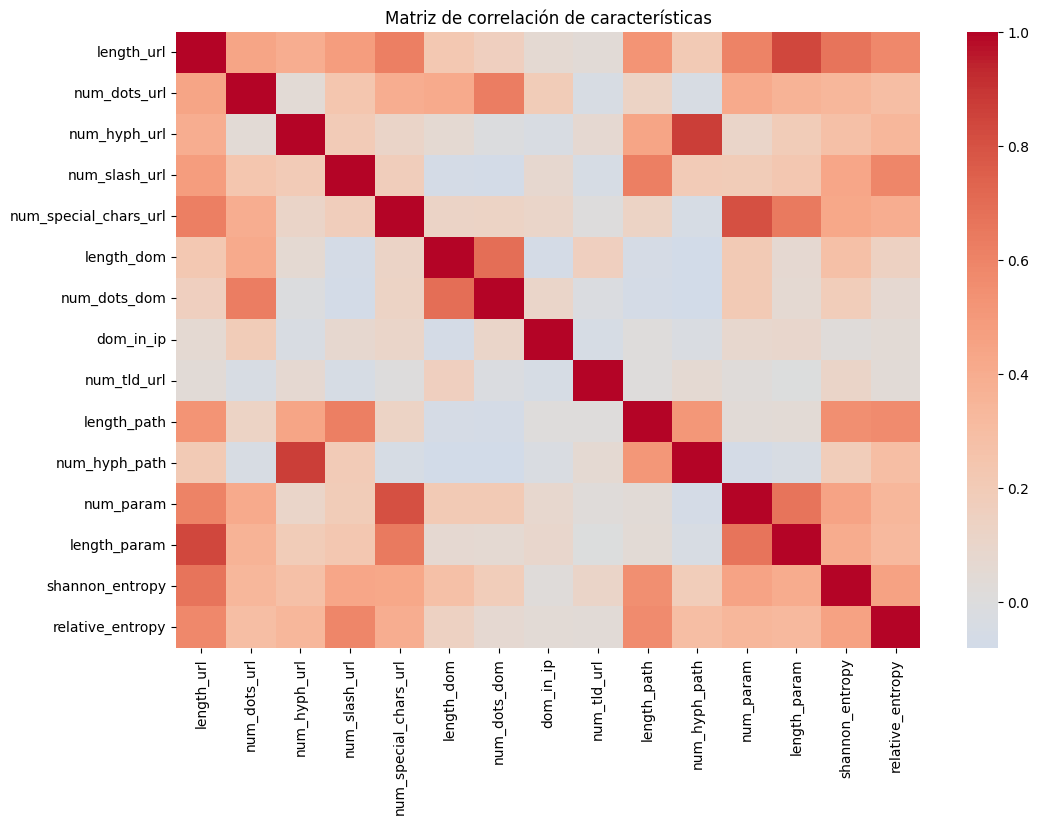

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de correlación de características")
plt.show()


Mutual Information ranking:
shannon_entropy          0.105433
num_dots_dom             0.086304
length_url               0.068347
length_dom               0.065065
num_dots_url             0.064646
length_param             0.063751
relative_entropy         0.058523
num_param                0.049369
num_special_chars_url    0.046122
length_path              0.045850
num_hyph_path            0.038230
num_slash_url            0.034202
num_hyph_url             0.031625
num_tld_url              0.015973
dom_in_ip                0.007066
dtype: float64


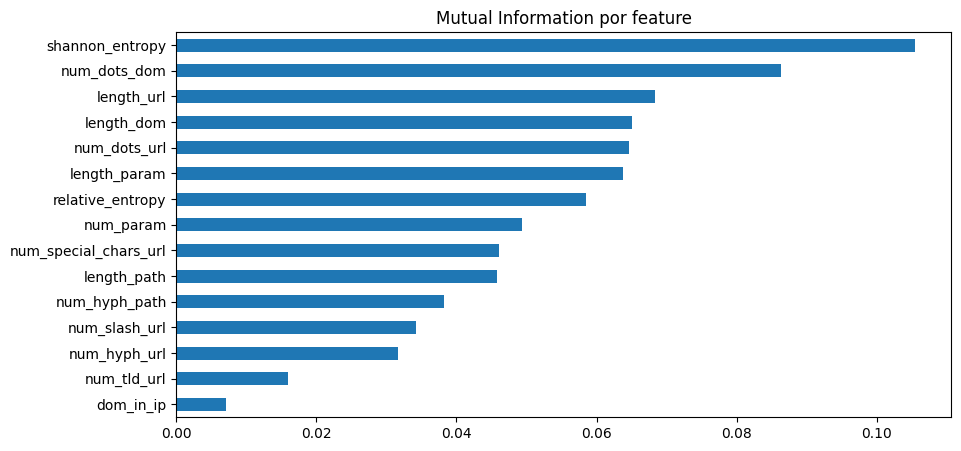

In [35]:
mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print("\nMutual Information ranking:")
print(mi_series)

plt.figure(figsize=(10, 5))
mi_series.sort_values().plot(kind="barh")
plt.title("Mutual Information por feature")
plt.show()

In [39]:
TOP_N = 13
selected_features = mi_series.head(TOP_N).index.tolist()

X_selected = X[selected_features]

print("\nFeatures seleccionadas:")
for feature in selected_features:
    print(f" - {feature}")


Features seleccionadas:
 - shannon_entropy
 - num_dots_dom
 - length_url
 - length_dom
 - num_dots_url
 - length_param
 - relative_entropy
 - num_param
 - num_special_chars_url
 - length_path
 - num_hyph_path
 - num_slash_url
 - num_hyph_url


# Parte 2
## Separación de datos

In [41]:
# 30% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.30, random_state=42, stratify=y
)

# ahora del 70% restante:
# train debe ser 55/70 = 0.7857
train_ratio = 0.55 / 0.70

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=(1-train_ratio), random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (6285, 13)
Val: (1715, 13)
Test: (3429, 13)


In [47]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

folder_name= "mymodel"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

train_df.to_csv(os.path.join(folder_name,"train_dataset.csv"), index=False)
val_df.to_csv(os.path.join(folder_name,"val_dataset.csv"), index=False)
test_df.to_csv(os.path.join(folder_name,"test_dataset.csv"), index=False)

print("Datasets guardados como CSV.")

Datasets guardados como CSV.


## Implementación

Modelos a usar:
- Logisitic Regression
- Random Forest

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score,
    roc_curve, auc
)

**Logistic Regression**

In [49]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

**Random forest**

In [50]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=None
)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### Evaluación

In [87]:
def evaluar_modelo(model, X_data, y_data, nombre="Modelo"):
    y_pred = model.predict(X_data)
    
    # probabilidades para ROC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_data)[:, 1]
    else:
        # fallback si el modelo no tiene predict_proba
        y_prob = model.decision_function(X_data)

    # métricas
    precision = precision_score(y_data, y_pred)
    recall = recall_score(y_data, y_pred)

    cm = confusion_matrix(y_data, y_pred)
    print(f"\n--- {nombre} ---")
    print("Precision:", precision)
    print("Recall:", recall)
    print("Confusion Matrix:\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.RdPu)
    plt.title(f"Matriz de confusión\n{nombre}")
    plt.show()

    # ROC + AUC
    fpr, tpr, thresholds = roc_curve(y_data, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color = '#f28482')
    plt.plot([0, 1], [0, 1], linestyle="--", color = '#a2d2ff', label = "Random sorter")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve\n{nombre}")
    plt.legend()
    plt.show()

    return precision, recall, roc_auc

VALIDACIÓN

--- Logistic Regression (Val) ---
Precision: 0.7355263157894737
Recall: 0.6522753792298717
Confusion Matrix:
 [[657 201]
 [298 559]]


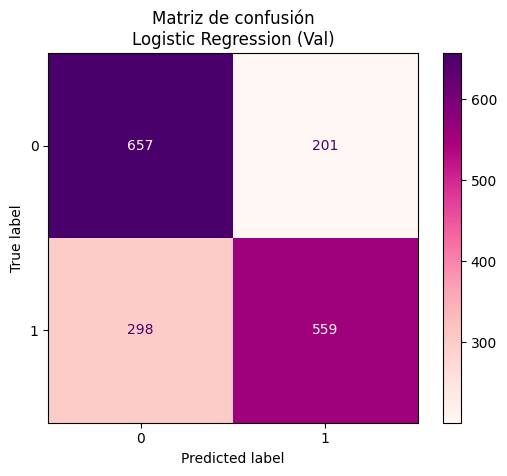

ROC AUC: 0.7903736675615323


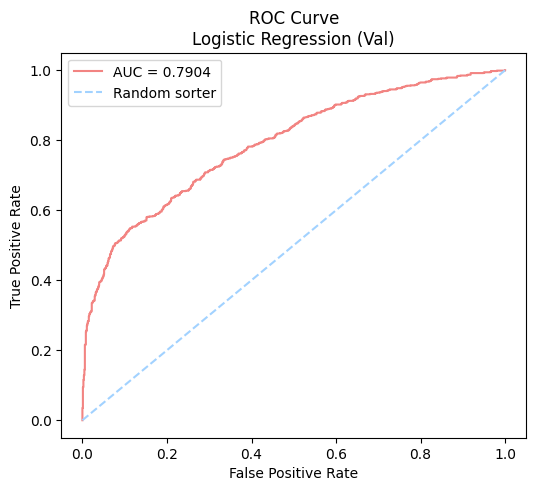


--- Random Forest (Val) ---
Precision: 0.8265550239234449
Recall: 0.8063010501750292
Confusion Matrix:
 [[713 145]
 [166 691]]


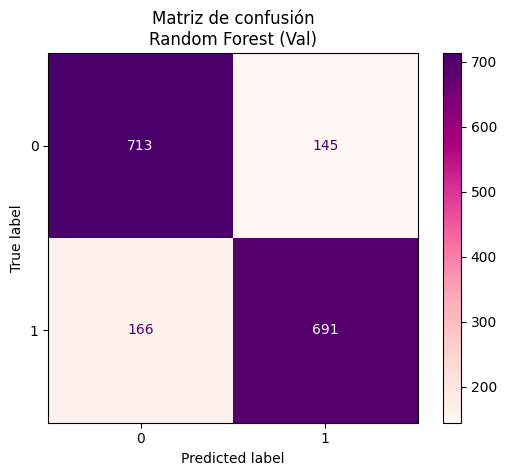

ROC AUC: 0.9033953211316106


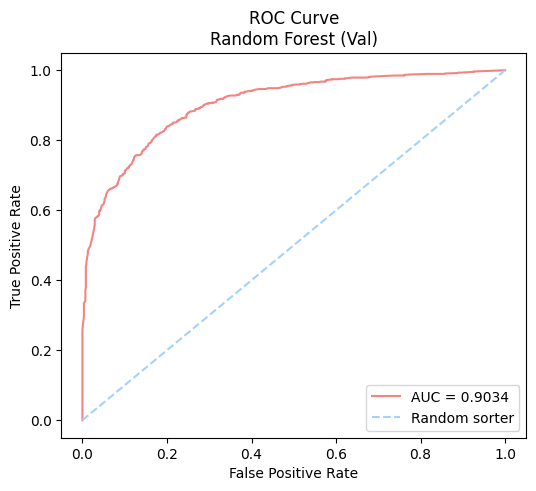

In [88]:
print("VALIDACIÓN")
eval_log_val = evaluar_modelo(log_reg, X_val, y_val, "Logistic Regression (Val)")
eval_rf_val = evaluar_modelo(rf, X_val, y_val, "Random Forest (Val)")

PRUEBA

--- Logistic Regression (Test) ---
Precision: 0.7460606060606061
Recall: 0.7182030338389732
Confusion Matrix:
 [[1296  419]
 [ 483 1231]]


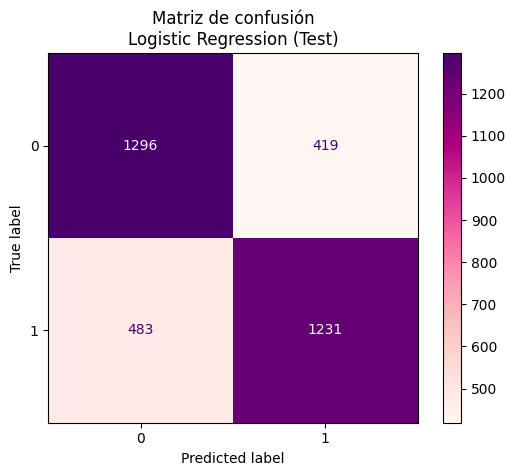

ROC AUC: 0.8132135968239604


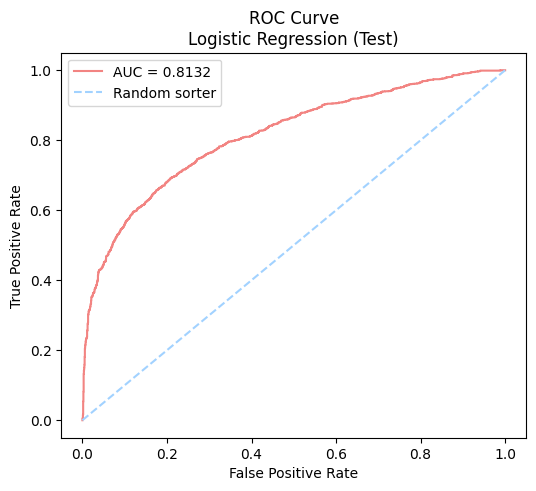


--- Random Forest (Test) ---
Precision: 0.8276670574443142
Recall: 0.823803967327888
Confusion Matrix:
 [[1421  294]
 [ 302 1412]]


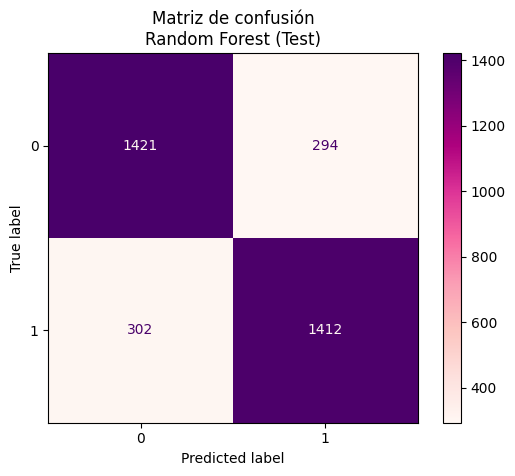

ROC AUC: 0.9125764157971906


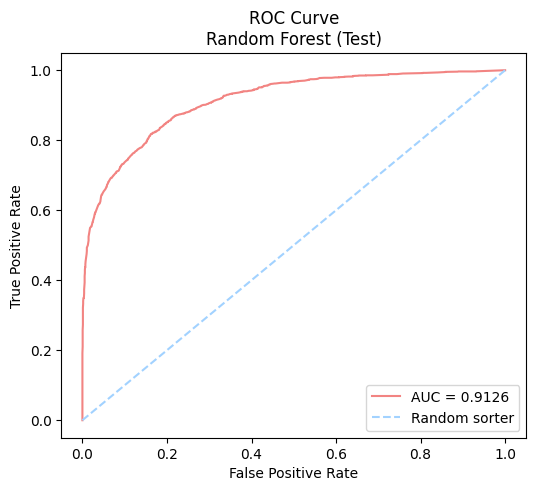

In [89]:
print("PRUEBA")
eval_log_test = evaluar_modelo(log_reg, X_test, y_test, "Logistic Regression (Test)")
eval_rf_test = evaluar_modelo(rf, X_test, y_test, "Random Forest (Test)")
